Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking, CmdStan, StanMCMCChain, LinearAlgebra
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "04")
cd(ProjDir)

### snippet 4.7

In [3]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df);
first(df2, 5)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0


Use data from m4.1s

Check if the m4.1s.jls file is present. If not, run the model.

In [5]:
!isfile(joinpath(ProjDir, "m4.1s.jls")) && include(joinpath(ProjDir, "m4.1s.jl"))

chn = deserialize(joinpath(ProjDir, "m4.1s.jls"))

Object of type "Chains{Float64}"

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Union{Missing, Float64}[8.17866 154.781; 7.74992 153.8; … ; 7.0895 154.662; 8.35746 154.131]

Union{Missing, Float64}[7.44336 154.147; 8.04039 154.996; … ; 7.86273 154.617; 7.55352 154.504]

Union{Missing, Float64}[7.68133 154.977; 7.91333 154.636; … ; 7.42084 154.584; 8.44296 154.631]

Union{Missing, Float64}[8.24809 155.325; 7.15496 153.948; … ; 7.79321 154.782; 7.86666 154.773]

Describe the draws

In [6]:
describe(chn)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
         Mean       SD       Naive SE       MCSE      ESS
sigma   7.76166 0.28999536 0.0045852292 0.0049853769 1000
   mu 154.60541 0.41377360 0.0065423351 0.0066468785 1000

Quantiles:
          2.5%       25.0%      50.0%      75.0%       97.5%  
sigma   7.2247865   7.5591875   7.75025   7.9487125   8.356166
   mu 153.8019750 154.3240000 154.59300 154.8902500 155.432075



Plot the density of posterior draws

┌ Warning: seriestype density has been moved to StatPlots.  To use: `Pkg.add("StatPlots"); using StatPlots`
└ @ Plots /Users/rob/.julia/packages/Plots/qh1wV/src/args.jl:1054
┌ Warning: seriestype density has been moved to StatPlots.  To use: `Pkg.add("StatPlots"); using StatPlots`
└ @ Plots /Users/rob/.julia/packages/Plots/qh1wV/src/args.jl:1054
┌ Warning: seriestype density has been moved to StatPlots.  To use: `Pkg.add("StatPlots"); using StatPlots`
└ @ Plots /Users/rob/.julia/packages/Plots/qh1wV/src/args.jl:1054
┌ Warning: seriestype density has been moved to StatPlots.  To use: `Pkg.add("StatPlots"); using StatPlots`
└ @ Plots /Users/rob/.julia/packages/Plots/qh1wV/src/args.jl:1054
┌ Warning: seriestype density has been moved to StatPlots.  To use: `Pkg.add("StatPlots"); using StatPlots`
└ @ Plots /Users/rob/.julia/packages/Plots/qh1wV/src/args.jl:1054
┌ Warning: seriestype density has been moved to StatPlots.  To use: `Pkg.add("StatPlots"); using StatPlots`
└ @ Plots /Users/rob/.

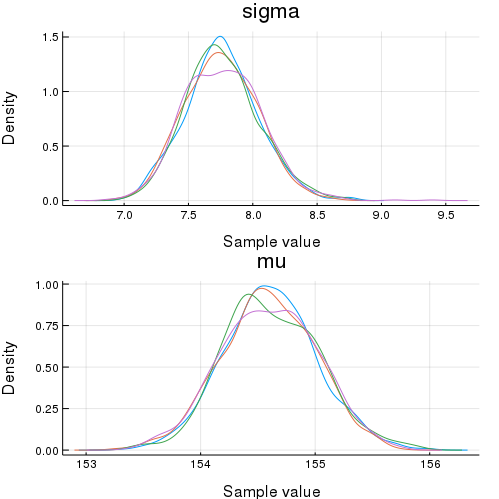

In [7]:
density(chn, lab="All heights", xlab="height [cm]", ylab="density")

Compute cor

In [8]:
mu_sigma = hcat(chn.value[:, 2, 1], chn.value[:,1, 1])
LinearAlgebra.diag(cov(mu_sigma))

2-element Array{Float64,1}:
 0.1645082872312309
 0.0819537197628765

Compute cov

In [9]:
cor(mu_sigma)

2×2 Array{Float64,2}:
  1.0        -0.0270588
 -0.0270588   1.0      

End of `clip_07.0s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*